In [60]:
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# Recopilación de un conjunto diverso de imágenes en diferentes estilos artísticos, a partir del repositorio.

# Preparación de los datos, justificando las decisiones tomadas

In [2]:
# Class to read and preprocess images
class ImageReader:
    """Class to read and preprocess images.

    Attributes:
        - n_images (int): Number of images to read
        - file_type (str): File type of the images
        - directory (str): Directory where the images are stored

    Preprocessing includes:
    - Reading the images
    - Rescaling the images keeping the aspect ratio
    """

    def __init__(self, n_images: int, file_type: str, directory: str, scale: float = 0.1):
        self.images_names = []
        self.n_images = n_images
        self.file_type = file_type
        self.directory = directory
        self.images = self.read_images()
        self.images = self.rescale_images(self.images, scale)

    def read_images(self):
        """Read images from a directory and store them in a list"""
        # select n_images random files for each art style
        files = []
        for dirname, _, filenames in os.walk(self.directory):
            if len(filenames) > self.n_images:
                chosen_files = random.sample(filenames, self.n_images)
            else:
                chosen_files = filenames

            for filename in chosen_files:
                if filename.endswith(self.file_type):
                    files.append(os.path.join(dirname, filename))

        # read n random images from all the files
        images = []
        files = random.sample(files, self.n_images)
        for file in files:
            image = cv2.imread(file)
            images.append(image)
            self.images_names.append(file.split('/')[-1])
        return images

    def rescale_images(self, images: list, scale: float = 0.5):
        """Rescale images keeping the aspect ratio"""
        rescaled_images = []
        for image in images:
            width = int(image.shape[1] * scale)
            height = int(image.shape[0] * scale)
            dim = (width, height)
            rescaled_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            rescaled_images.append(rescaled_image)
        return rescaled_images

    def plot_images(self):
        """Plot the images"""
        n_cols = 3
        n_rows = int(np.ceil(self.n_images / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
        for i, ax in enumerate(axs.flat):
            if i < self.n_images:
                ax.imshow(cv2.cvtColor(self.images[i], cv2.COLOR_BGR2RGB))
                ax.axis('off')
                ax.set_title(self.images_names[i])
        plt.show()


class ImageDataProcessor:
    """Class to process images and extract features.

    Attributes:
        - image_reader: Instance of the ImageReader class.

    Methods:
        - extract_features: Extract features from the images
    """

    def __init__(self, image_reader: ImageReader):
        self.image_reader = image_reader
        if len(self.image_reader.images) > 1:
            self.image_reader.images = self.resize_images((100, 100))
        self.features = self.extract_features()

    def extract_features(self):
        """Create DataFrame with RGB values of the images"""
        features = []
        for image in self.image_reader.images:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.reshape((image.shape[0] * image.shape[1], 3))
            features.append(image)
        features = np.concatenate(features, axis=0)
        features = pd.DataFrame(features, columns=['r', 'g', 'b'])
        return features
    
    def resize_images(self, size: tuple):
        """Resize images to a given size"""
        resized_images = []
        for image in self.image_reader.images:
            resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_image)
        return resized_images

In [3]:
images = ImageReader(n_images=3, file_type='.jpg', directory='/kaggle/input')

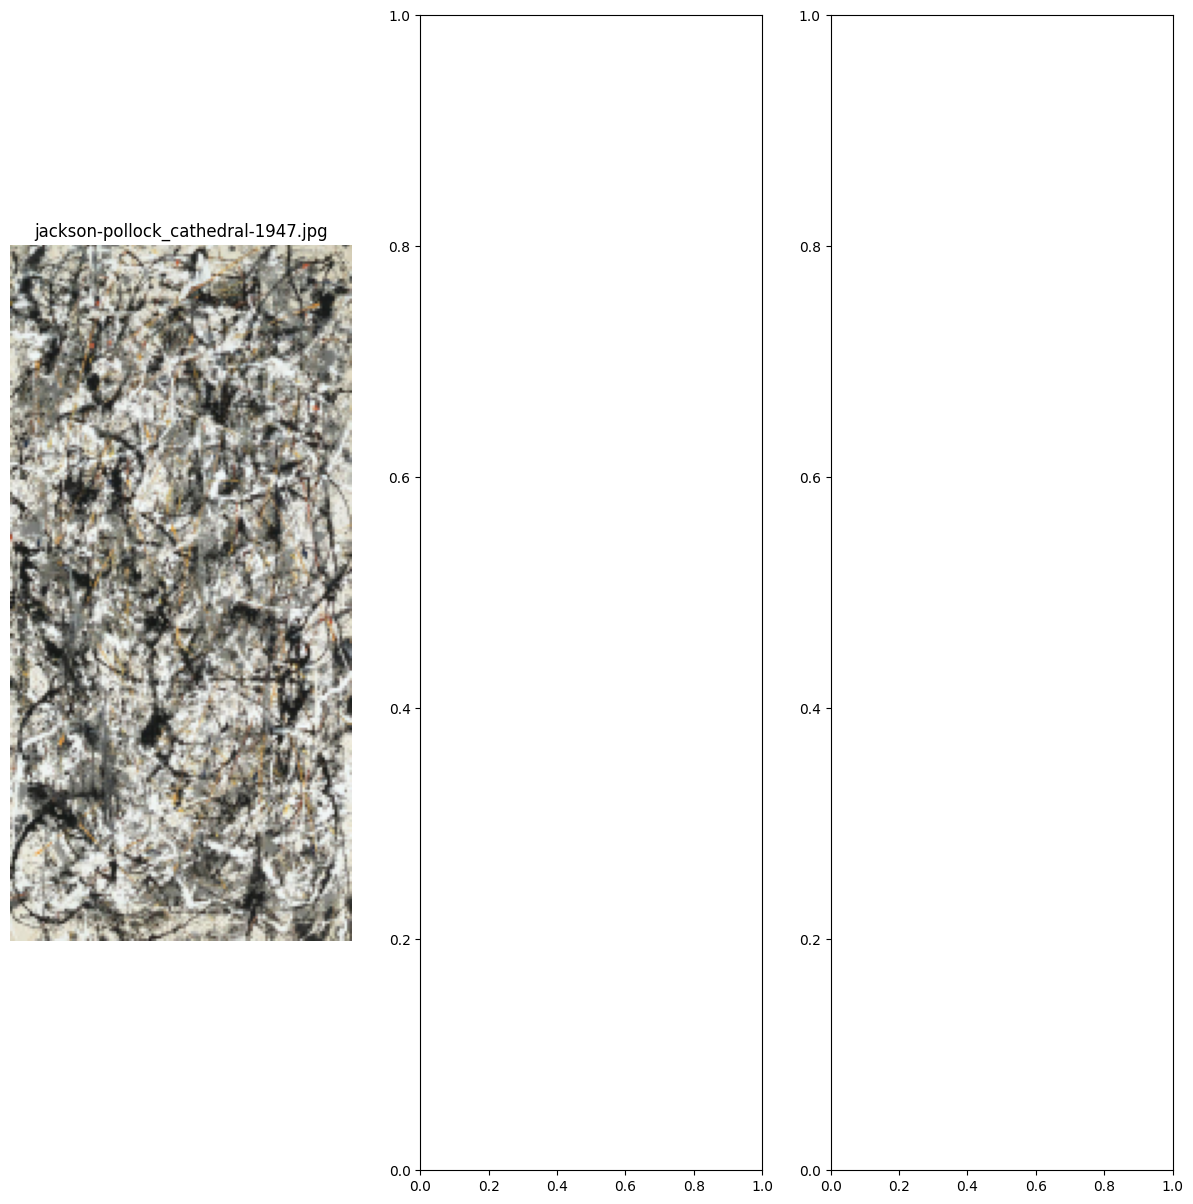

In [4]:
images.plot_images()

In [ ]:
images = ImageReader(n_images=1, file_type='.jpg', directory='/kaggle/input')

### Decisiones
1. Se utiliza un factor de rescalamiento de 0,1 con el fin de optimizar el procesamiento de las imágenes. Sin embargo se mantiene la relación de aspecto para no generar distorciones que afecten la escala.
2. No se usará un tamaño estandar ya que la idea es realizar el agrupamiento individualmente. Sin emabrgo, se mantiene la posibilidad de crear la paleta de colores para varias imágenes juntas por lo que se crea un método que ajusta los tamaños en todas las imágenes en caso de quererse utilizar.
3. Se realizará re-escalamiento de los datos ya que aunque cada canal vaya de 0 a 255, en imagenes más claras u oscuras los outliers afectarían algoritmos como kmeans y PCA que dependen de la escala.

## Construcción del pipeline de preparación de datos.

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from sklearn.metrics import silhouette_score, silhouette_samples

class ImageClustering:
    """Class to cluster images using different clustering algorithms.

    Attributes:
        - image_data_processor: Instance of the ImageDataProcessor class.
        - clusterer: Clustering algorithm to use.
        - kwargs: Additional parameters for the clustering algorithm.

    Methods:
        - fit: Fit the clustering algorithm to the data.
        - plot_clusters: Plot the images and their respective clusters.
    """
    
    def __init__(self, image_data_processor: ImageDataProcessor, clusterer, **kwargs):
        self.image_data_processor = image_data_processor
        self.clusterer = clusterer
        self.kwargs = kwargs
        self.pipeline = self.create_pipeline()

    def create_pipeline(self):
        """Create a pipeline for the clustering algorithm"""
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clusterer', self.clusterer(**self.kwargs))
        ])
        return pipeline

    def fit(self):
        """Fit the clustering algorithm to the data"""
        self.pipeline.fit(self.image_data_processor.features)

    def predict_one(self, image):
        """Predict the cluster of a single image"""
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.reshape((image.shape[0] * image.shape[1], 3))
        return self.pipeline.named_steps['clusterer'].predict(image)

    def plot_clusters(self):
        """Plot the images and their respective clusters"""
        # get cluster labels
        cluster_labels = self.pipeline.named_steps['clusterer'].labels_
        n_clusters = len(np.unique(cluster_labels))
        centroids = self.pipeline.named_steps['clusterer'].cluster_centers_
        rgb_values = self.pipeline.named_steps['scaler'].inverse_transform(centroids)
        rgb_values = rgb_values / 255
        
        def _add_infig_color_palette(fig, rgb_values, n_clusters):
            # add color palette to the figure
            ax = fig.add_axes([0.1, 0.9, 0.1, 0.1])
            ax.imshow([rgb_values], aspect='auto')
            ax.axis('off')
            ax.set_title('Color palette')
            return fig
        
        if len(self.image_data_processor.image_reader.images) == 1:
            fig, ax = plt.subplots(1, 1, figsize=(15, 15))
            ax.imshow(cv2.cvtColor(self.image_data_processor.image_reader.images[0], cv2.COLOR_BGR2RGB))
            ax.axis('off')
        else:
            n_cols = 3
            n_rows = int(np.ceil(len(self.image_data_processor.image_reader.images) / n_cols))
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
            for i, ax in enumerate(axs.flat):
                if i < len(self.image_data_processor.image_reader.images):
                    ax.imshow(cv2.cvtColor(self.image_data_processor.image_reader.images[i], cv2.COLOR_BGR2RGB))
                    ax.axis('off')
        fig = _add_infig_color_palette(fig, rgb_values, n_clusters)
        plt.show()

# Construcción de modelo de agrupación

In [8]:
class ClusteringEvaluator:
    """Class to evaluate performance of clustering algorithms.

    Attributes:
        - image_data_processor: Instance of the ImageDataProcessor class.
        - image_clustering: Instance of the ImageClustering class.

    Methods:
        - silhouette_score: Compute the silhouette score of the clustering algorithm.
        - silhouette_plot: Plot the silhouette plot of the clustering algorithm.
    """
    
    def __init__(self, image_data_processor: ImageDataProcessor, image_clustering: ImageClustering):
        self.image_data_processor = image_data_processor
        self.image_clustering = image_clustering

    def silhouette_score(self):
        """Compute the silhouette score of the clustering algorithm"""
        cluster_labels = self.image_clustering.pipeline.named_steps['clusterer'].labels_
        score = silhouette_score(self.image_data_processor.features, cluster_labels)
        return score

    def silhouette_plot(self):
        """Plot the silhouette plot of the clustering algorithm"""
        cluster_labels = self.image_clustering.pipeline.named_steps['clusterer'].labels_
        silhouette_values = silhouette_samples(self.image_data_processor.features, cluster_labels)
        y_lower = 10
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        for i in range(len(np.unique(cluster_labels))):
            cluster_silhouette_values = silhouette_values[cluster_labels == i]
            cluster_silhouette_values.sort()
            size_cluster_i = cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / len(np.unique(cluster_labels)))
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        ax.set_title('Silhouette plot')
        ax.set_xlabel('Silhouette values')
        ax.set_ylabel('Cluster label')
        ax.axvline(x=self.silhouette_score(), color='red', linestyle='--')
        ax.set_yticks([])
        plt.show()

## Selección del modelo

In [14]:
# Lista de hiperparámetros
n_clusters = [2, 3, 4]
bandwidths = [0.001, 0.005, 0.01, 0.1]
eps = [0.001, 0.005, 0.01, 0.1]
n_points = [2, 3, 4, 5]

image_data_processor = ImageDataProcessor(images)

### K means

In [11]:
for n_cluster in n_clusters:
    image_clustering = ImageClustering(image_data_processor, KMeans, n_clusters=n_cluster, n_init="auto")
    image_clustering.fit()
    clustering_evaluator = ClusteringEvaluator(image_data_processor, image_clustering)
    print(f'KMeans with {n_cluster} clusters: {clustering_evaluator.silhouette_score()}')

KMeans with 2 clusters: 0.5813657833203384
KMeans with 3 clusters: 0.554824414455898
KMeans with 4 clusters: 0.529217600031566


### Algoritmos Jerárquicos

In [12]:
for n_cluster in n_clusters:
    image_clustering = ImageClustering(image_data_processor, AgglomerativeClustering, n_clusters=n_cluster)
    image_clustering.fit()
    clustering_evaluator = ClusteringEvaluator(image_data_processor, image_clustering)
    print(f'Agglomerative with {n_cluster} clusters: {clustering_evaluator.silhouette_score()}')

Agglomerative with 2 clusters: 0.5718037668483332
Agglomerative with 3 clusters: 0.5096416604835707
Agglomerative with 4 clusters: 0.5038771509527348


### Algoritmos basados en densidad

In [63]:
for e in eps:
    for n in n_points:
        image_clustering = ImageClustering(image_data_processor, DBSCAN, eps=e, min_samples=n)
        image_clustering.fit()
        clustering_evaluator = ClusteringEvaluator(image_data_processor, image_clustering)
        print(f'DBSCAN with eps={e} and min_samples={n}: {clustering_evaluator.silhouette_score()}')

DBSCAN with eps=0.001 and min_samples=2: -0.4959904859206681
DBSCAN with eps=0.001 and min_samples=3: -0.7969324654487889
DBSCAN with eps=0.001 and min_samples=4: -0.8147886300470515
DBSCAN with eps=0.001 and min_samples=5: -0.7501144000343276
DBSCAN with eps=0.005 and min_samples=2: -0.4959904859206681
DBSCAN with eps=0.005 and min_samples=3: -0.7969324654487889
DBSCAN with eps=0.005 and min_samples=4: -0.8147886300470515
DBSCAN with eps=0.005 and min_samples=5: -0.7501144000343276
DBSCAN with eps=0.01 and min_samples=2: -0.4959904859206681
DBSCAN with eps=0.01 and min_samples=3: -0.7969324654487889
DBSCAN with eps=0.01 and min_samples=4: -0.8147886300470515
DBSCAN with eps=0.01 and min_samples=5: -0.7501144000343276
DBSCAN with eps=0.1 and min_samples=2: -0.6470418720800772
DBSCAN with eps=0.1 and min_samples=3: -0.5245592802182363
DBSCAN with eps=0.1 and min_samples=4: 0.06326060441771528
DBSCAN with eps=0.1 and min_samples=5: 0.04967479962532053


### Algoritmos Híbridos

In [ ]:
for bw in bandwidths:
    image_clustering = ImageClustering(image_data_processor, MeanShift, bandwidth=bw)
    image_clustering.fit()
    clustering_evaluator = ClusteringEvaluator(image_data_processor, image_clustering)
    print(f'MeanShift with bandwidth={bw}: {clustering_evaluator.silhouette_score()}')

MeanShift with bandwidth=0.1: 0.20384997611315445


In [ ]:
for n_cluster in n_clusters:
    image_clustering = ImageClustering(image_data_processor, SpectralClustering, n_clusters=n_cluster)
    image_clustering.fit()
    clustering_evaluator = ClusteringEvaluator(image_data_processor, image_clustering)
    print(f'SpectralClustering with {n_cluster} clusters: {clustering_evaluator.silhouette_score()}')

## Selección de modelo

1. El algoritmo de clustering jerárquico y k means tienen buen rendimiento con 2 clusters.
2. El DBSCAN no posee tan buen rendimiento ya que su coeficiente de silueta es cercano a -1.

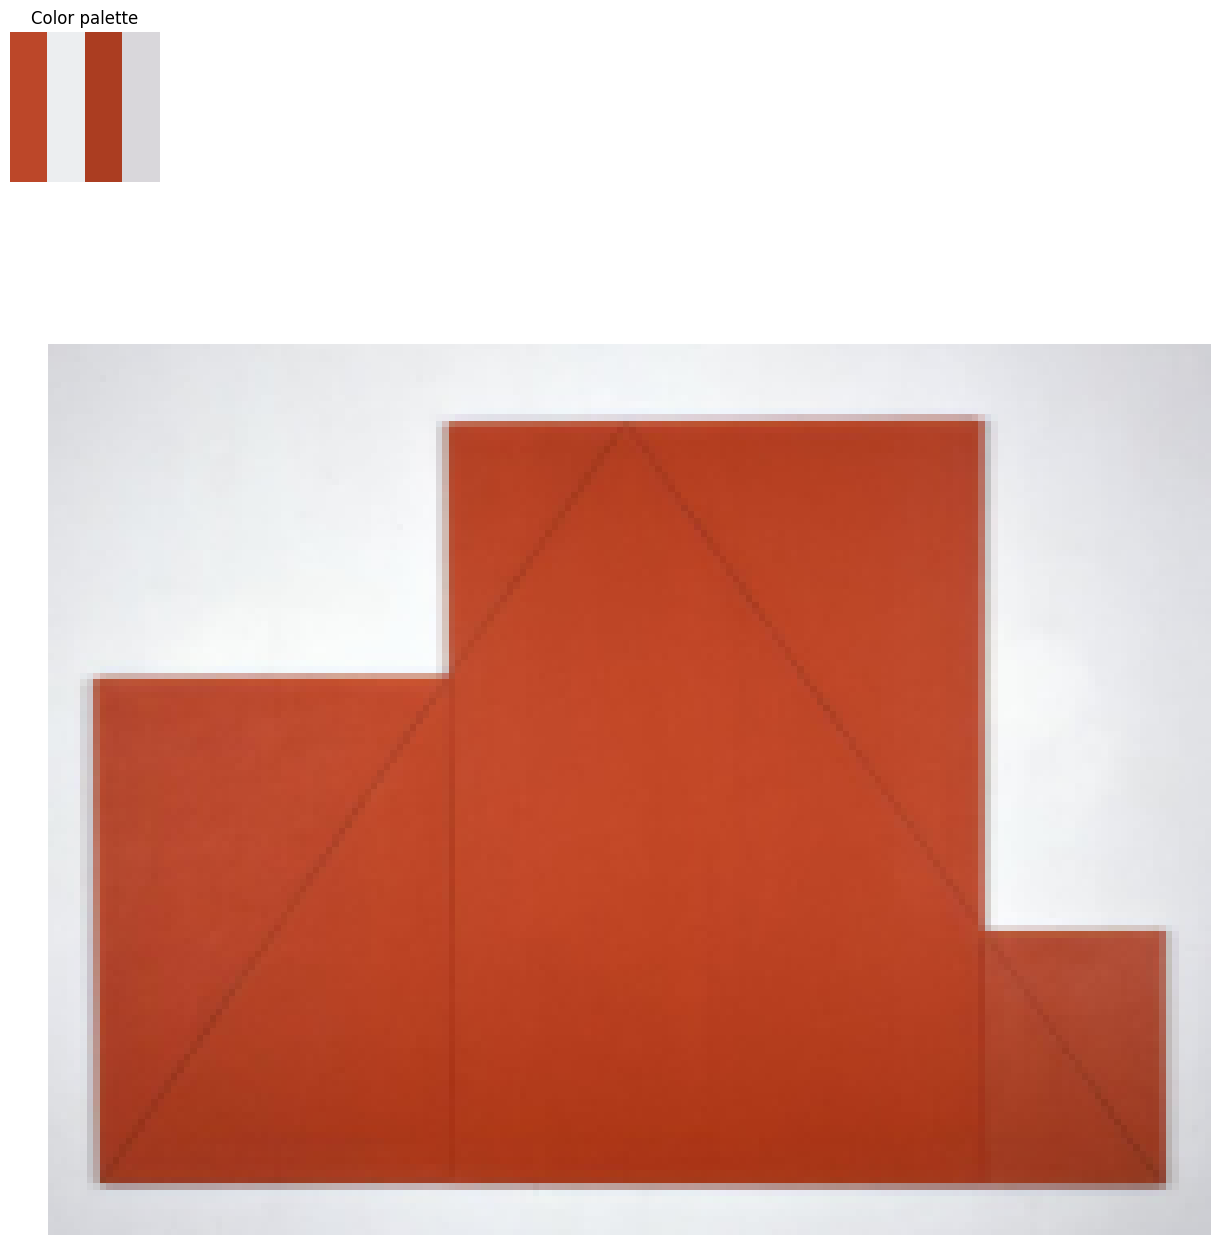

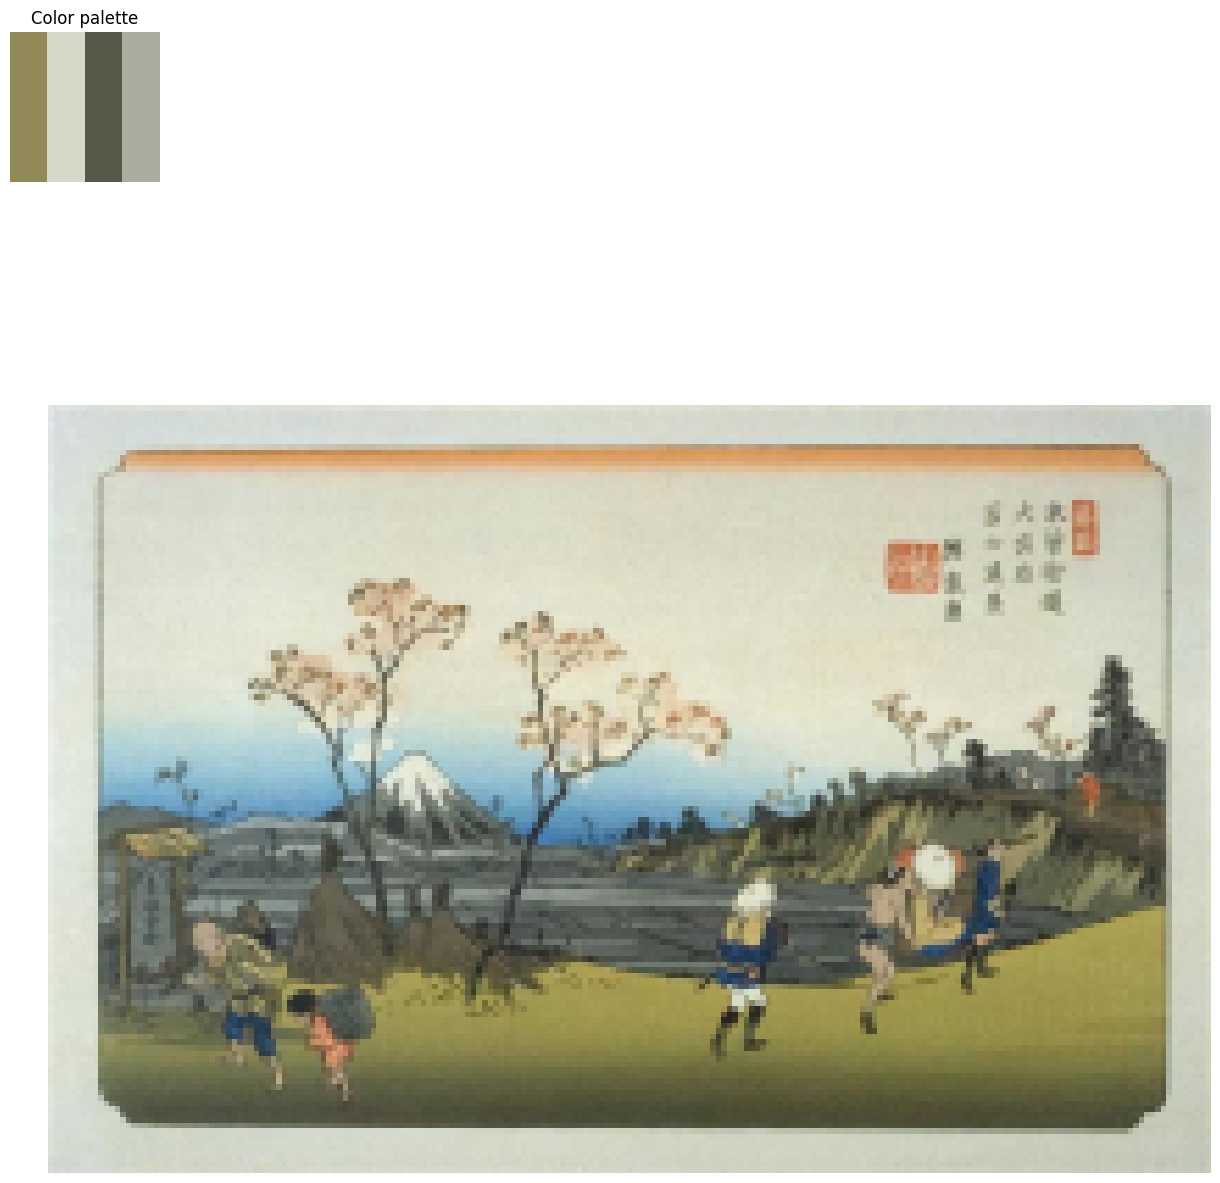

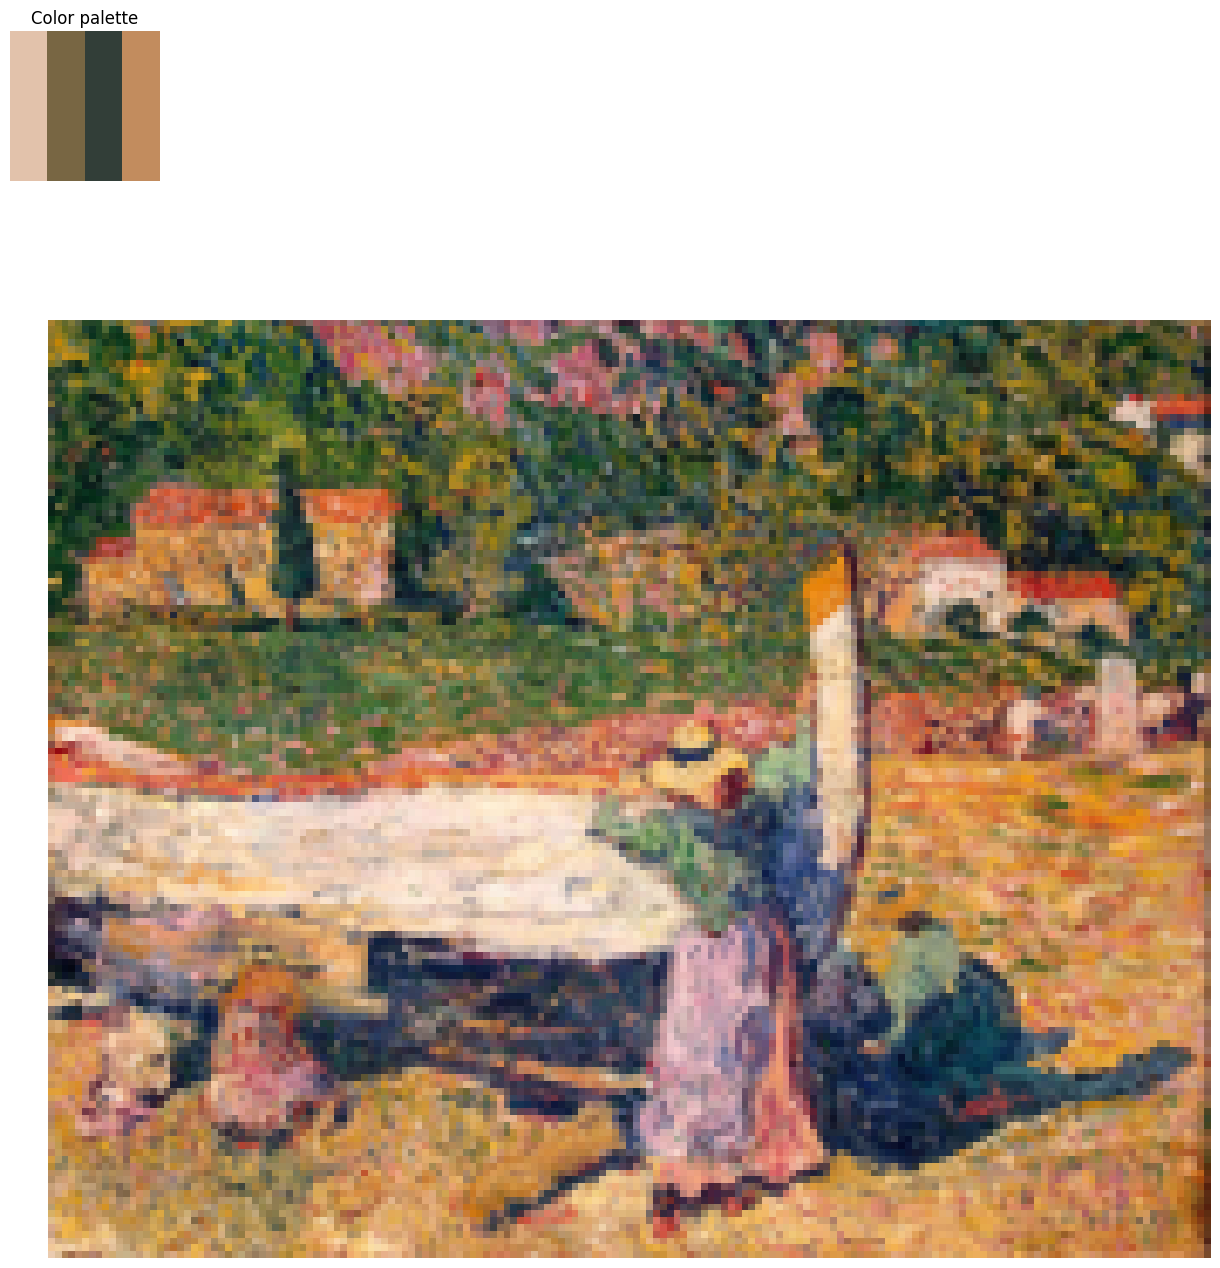

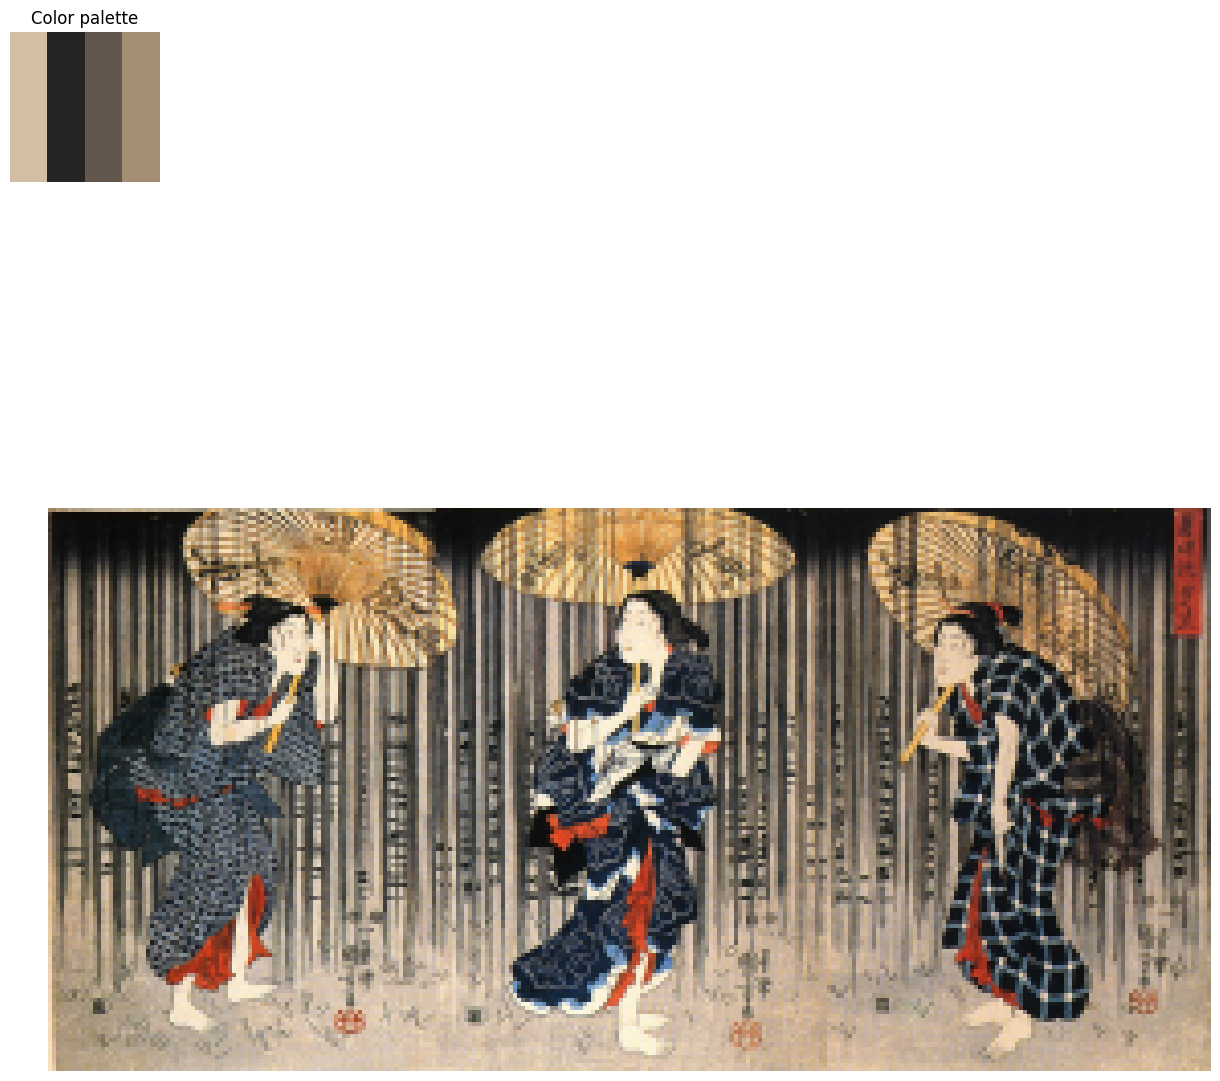

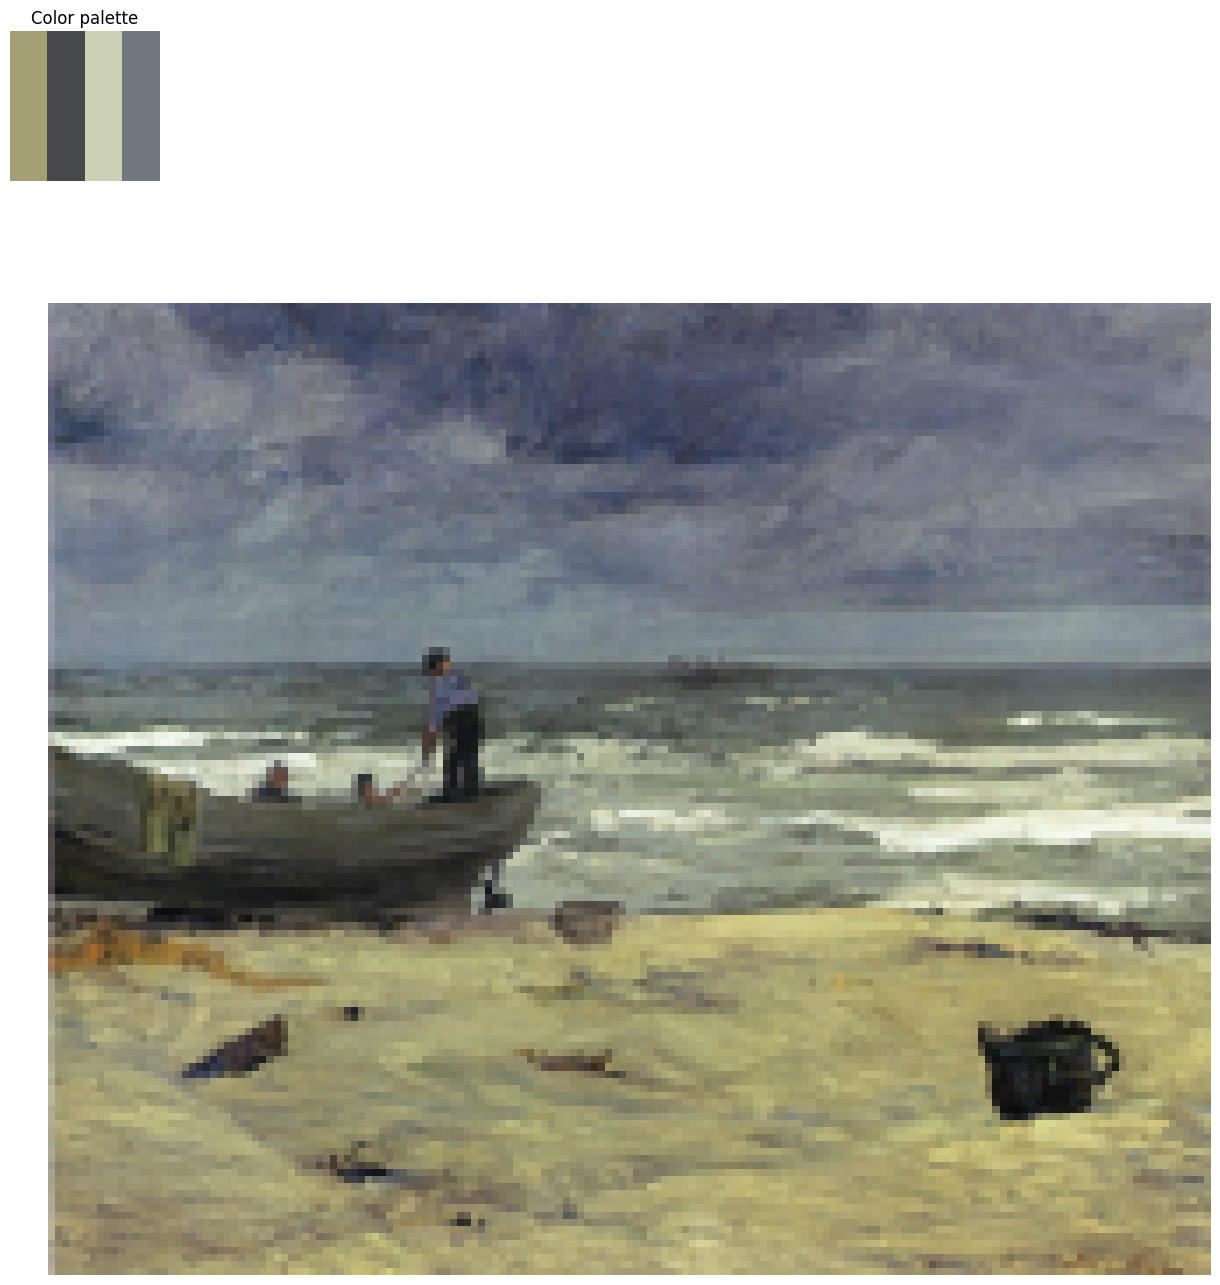

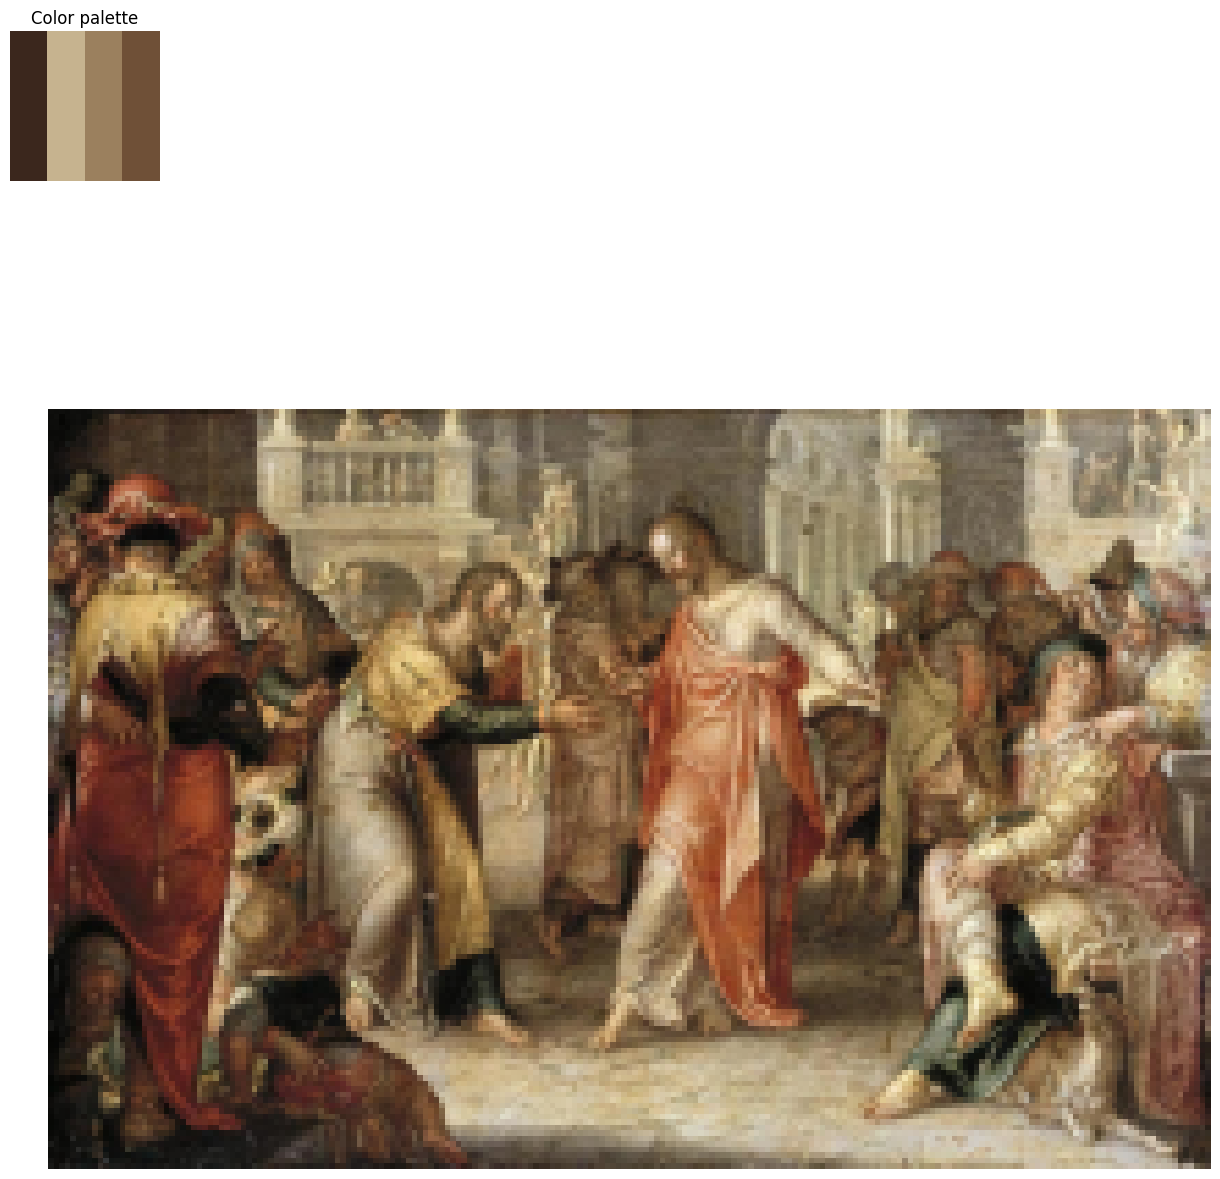

In [62]:
for i in range(6):
    images = ImageReader(n_images=1, file_type='.jpg', directory='/kaggle/input')
    image_data_processor = ImageDataProcessor(images)
    image_clustering = ImageClustering(image_data_processor, KMeans, n_clusters=4, n_init="auto")
    image_clustering.fit()
    image_clustering.plot_clusters()

## Aplicar los algoritmos PCA y t-SNE para la reducción de la dimensionalidad y visualización de conjuntos de datos

In [57]:
class DimReducer:
    """Class to reduce dimensions usin t-sne and pca
    
    Attributes:
        - image_processor: ImageProcessor instance
        - image_clustering: ImageClustering instance
    
    Methods:
        - pca_reduction: reduce dims using pca
        - tsne_reduction: reduce dims using t-sne
    """
    def __init__(self, image_processor: ImageDataProcessor, image_clustering: ImageClustering) -> None:
        self.image_processor = image_processor
        self.image_clustering = image_clustering
        
    def get_variances(self):
        """Get the variance explained by all components"""
        pca = PCA()
        pca.fit(self.image_processor.features)
        return pca.explained_variance_ratio_
    
    def get_principal_components(self, n_components: int) -> np.array:
        """ Run PCA
        """
        pca = PCA(n_components=n_components)
        return pca.fit_transform(self.image_processor.features)
    
    def plot_variance(self):
        """Plot the variance explained by the components"""
        variances = [self.get_variances(i) for i in range(1, self.image_processor.features.shape[1])]
        plt.plot(variances)
        plt.xlabel('Number of components')
        plt.ylabel('Variance explained')
        plt.title('Variance explained by the components')
        plt.show()

    def plot_biplot(self, n_components: int):
        """Plot the biplot of the pca"""
        pca = PCA(n_components=n_components)
        pca.fit_transform(image_data_processor.features)
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        for i in range(pca.components_.shape[1]):
            ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.05, head_length=0.1, fc='r', ec='r')
            ax.text(pca.components_[0, i], pca.components_[1, i], image_data_processor.features.columns[i])
        ax.set_xlabel('First principal component')
        ax.set_ylabel('Second principal component')
        ax.set_title('Biplot')
        plt.show()
        
    def plot_pca(self, n_components: int):
        """Plot the pca"""
        pca = PCA(n_components=n_components)
        reduced_features = pca.fit_transform(self.image_processor.features)
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=self.image_clustering.pipeline.named_steps['clusterer'].labels_)
        ax.set_xlabel('First principal component')
        ax.set_ylabel('Second principal component')
        ax.set_title('PCA')
        plt.show()
        
    def get_tsne(self, n_components: int):
        """Run t-sne"""
        tsne = TSNE(n_components=n_components)
        return tsne.fit_transform(self.image_processor.features)
    
    def plot_tsne(self, n_components: int):
        """Plot the t-sne"""
        tsne = TSNE(n_components=n_components)
        reduced_features = tsne.fit_transform(self.image_processor.features)
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=self.image_clustering.pipeline.named_steps['clusterer'].labels_)
        ax.set_xlabel('First component')
        ax.set_ylabel('Second component')
        ax.set_title('t-SNE')
        plt.show()
        
    

In [58]:
dim_reducer = DimReducer(image_data_processor, image_clustering)

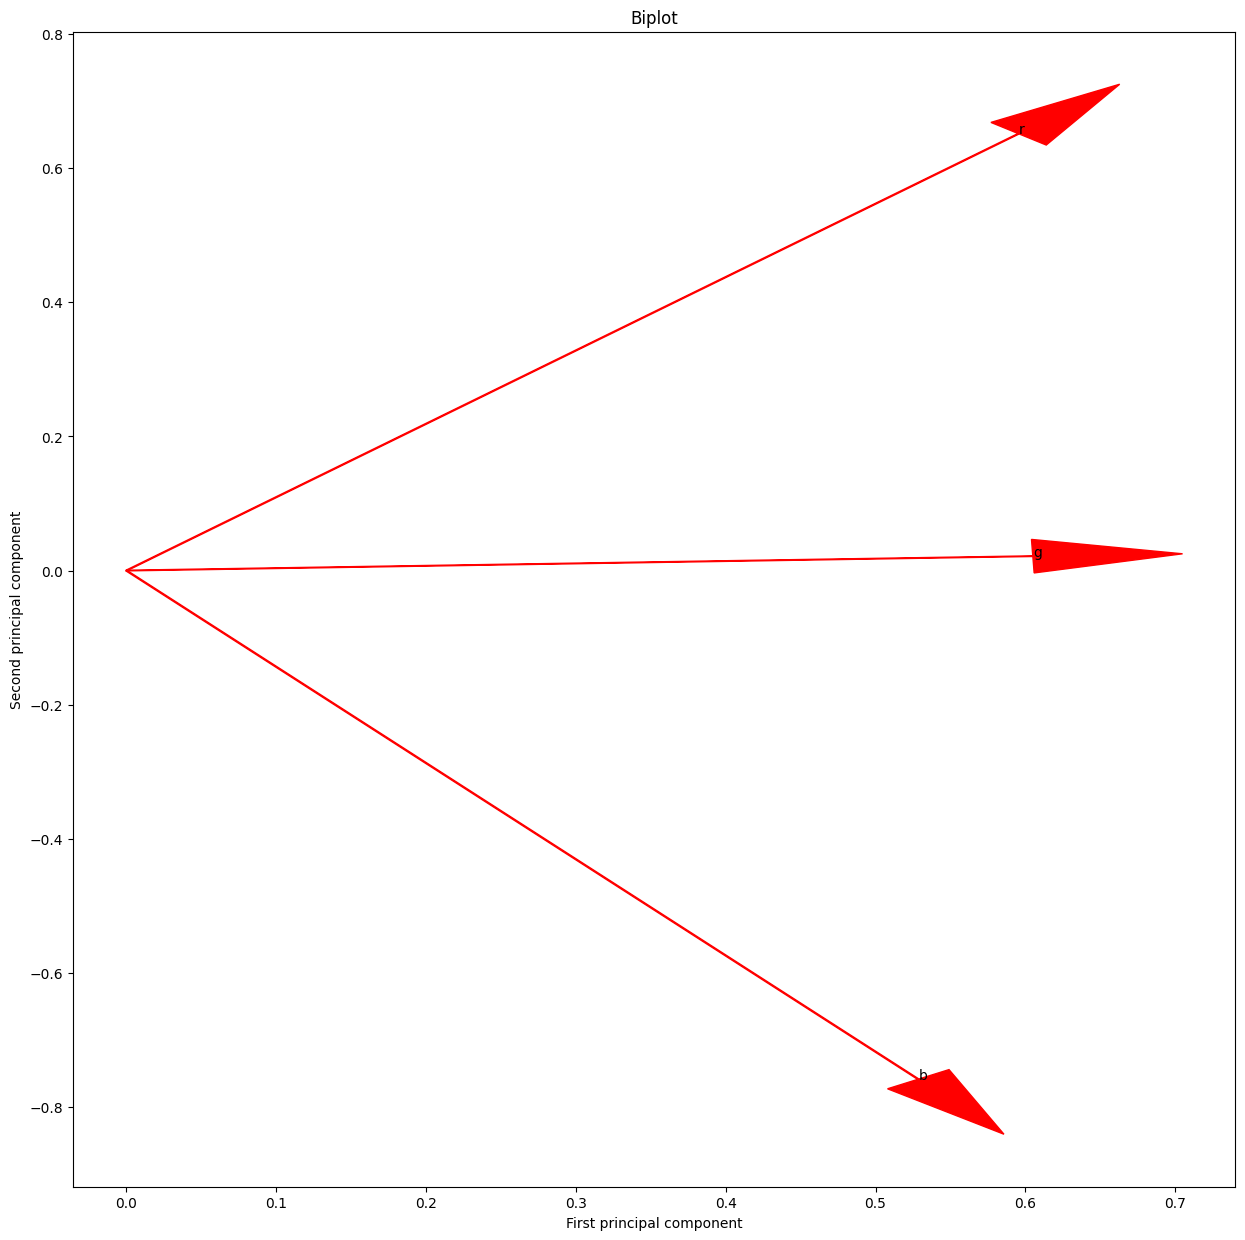

In [56]:
dim_reducer.plot_biplot(2)

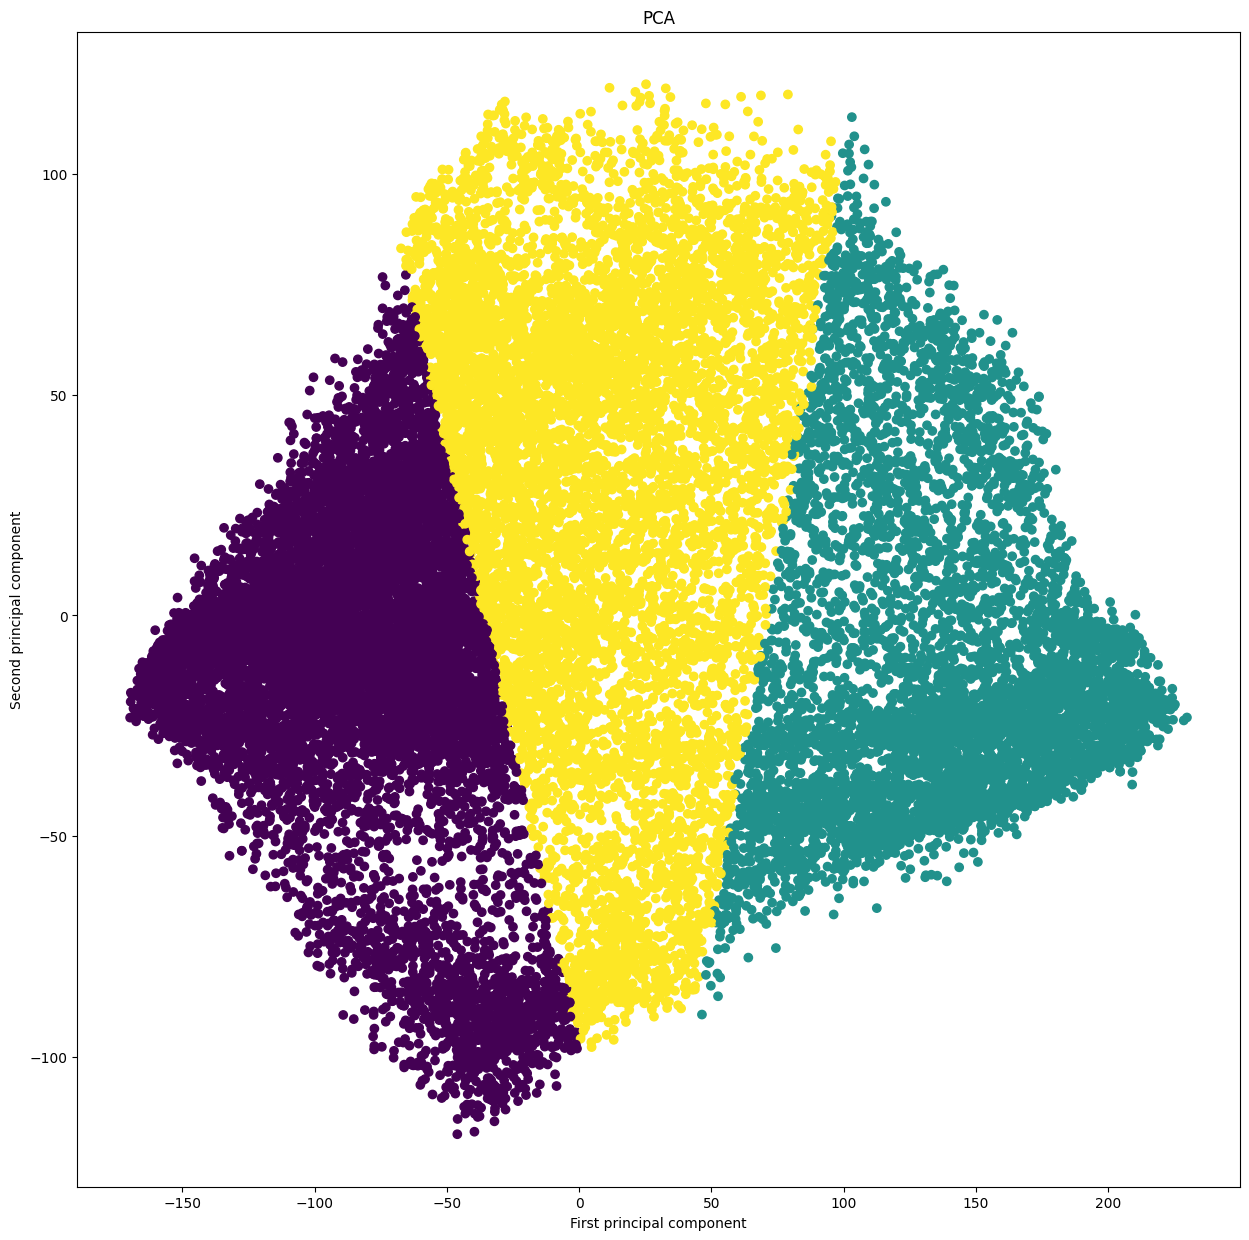

In [55]:
dim_reducer.plot_pca(2)

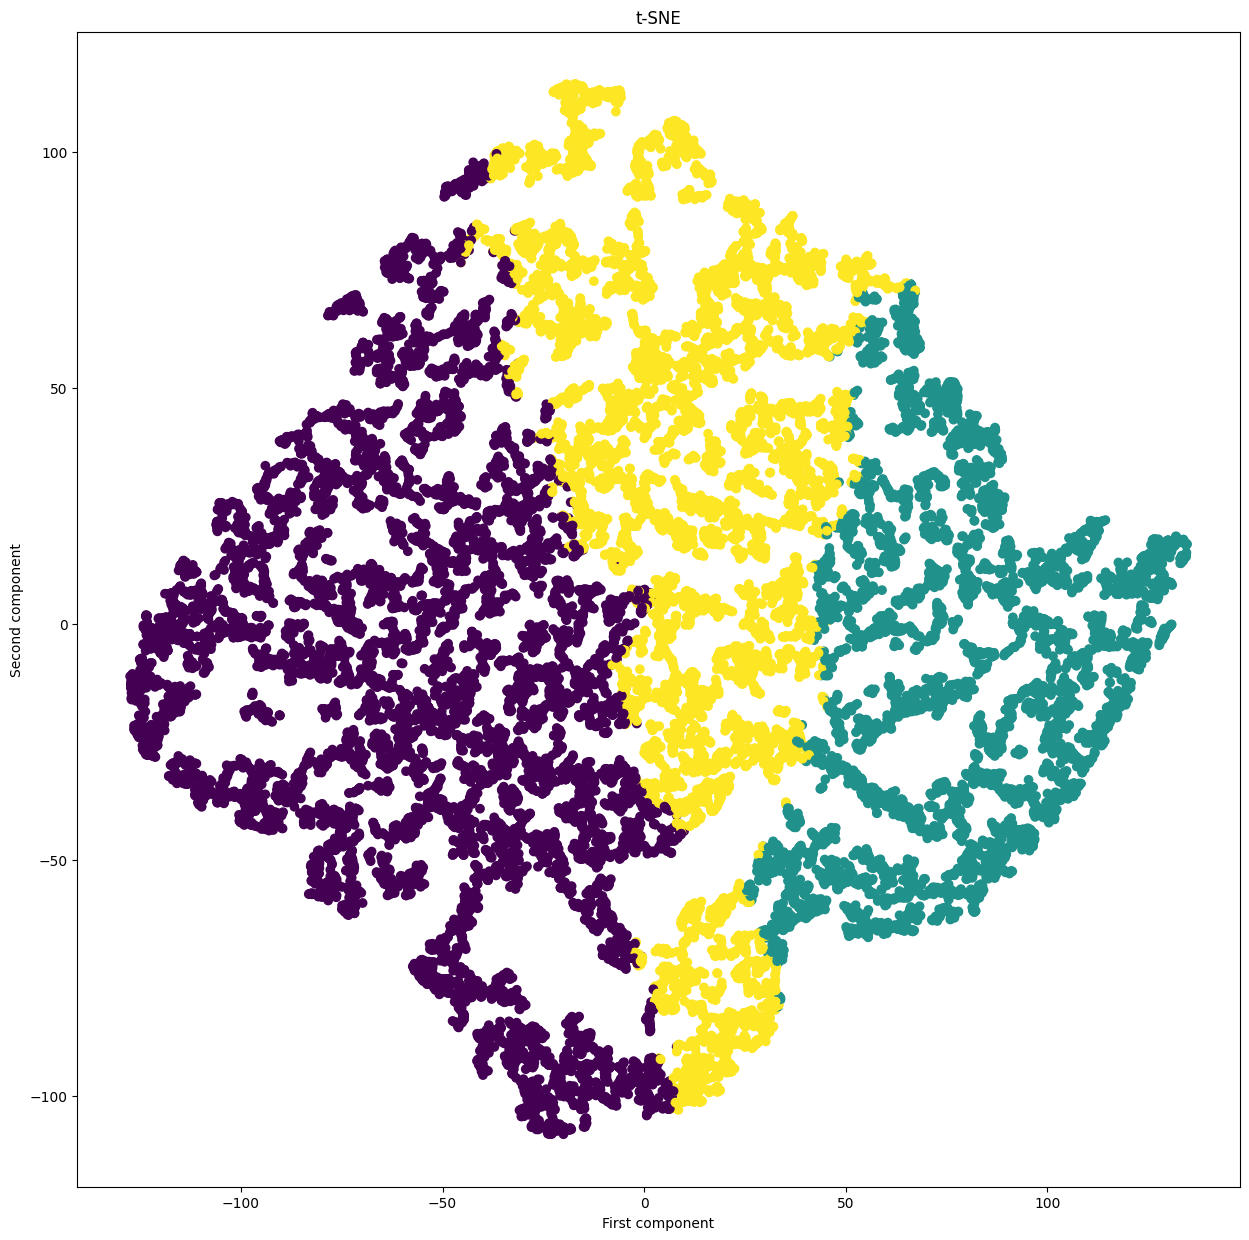

In [61]:
dim_reducer.plot_tsne(2)